In [1]:
pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.3 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import os
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
import evaluate
from sklearn.model_selection import train_test_split
import torch

In [3]:
from google.colab import files
uploaded = files.upload()

Saving IMDB Dataset.csv to IMDB Dataset.csv


In [4]:
import pandas as pd
from datasets import Dataset
df = pd.read_csv("IMDB Dataset.csv")
dataset = Dataset.from_pandas(df)

Sample record

In [5]:
dataset[:1]

{'review': ["One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is d

## distillBERT model implementation

In [6]:
CSV_PATH = "IMDB Dataset.csv"
TEXT_COL = "review"
LABEL_COL = "sentiment"
MODEL_NAME = "distilbert-base-uncased"
OUTPUT_DIR = "distilbert-imdb-sentiment"
MAX_LEN = 256
BATCH_SIZE = 16
LR = 2e-5
EPOCHS = 3
SEED = 42
TEST_SIZE = 0.10

In [7]:
df = pd.read_csv(CSV_PATH)

preprocessing dataset

In [8]:
import regex as re

In [13]:
def clean_text(t):
    t = re.sub(r"<br\s*/?>", " ", str(t), flags=re.IGNORECASE)
    t = re.sub(r"\s+", " ", t).strip()
    return t

def normalize_label(v):
    v = str(v).strip().lower()
    if v in {"pos", "positive", "1", "true"}: return "positive"
    if v in {"neg", "negative", "0", "false"}: return "negative"
    return v

df[TEXT_COL] = df[TEXT_COL].map(clean_text)
df[LABEL_COL] = df[LABEL_COL].map(normalize_label)

In [14]:
classes = sorted(df[LABEL_COL].unique().tolist())
label2id = {c:i for i,c in enumerate(classes)}
id2label = {i:c for c,i in label2id.items()}
df["label"] = df[LABEL_COL].map(label2id)

splitting into training and validation

In [28]:
from datasets import load_dataset, DatasetDict, ClassLabel

In [29]:
train_df, val_df = train_test_split(
    df, test_size=TEST_SIZE, random_state=SEED, stratify=df[LABEL_COL]
)


In [17]:
tok = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

train_encodings = tok(
    train_df[TEXT_COL].tolist(),
    truncation=True,
    max_length=MAX_LEN,
    padding=False
)
val_encodings = tok(
    val_df[TEXT_COL].tolist(),
    truncation=True,
    max_length=MAX_LEN,
    padding=False
)

In [18]:
train_labels = train_df["label"].astype(int).tolist()
val_labels = val_df["label"].astype(int).tolist()

In [19]:
train_dataset = Dataset.from_dict({
    "input_ids": train_encodings["input_ids"],
    "attention_mask": train_encodings["attention_mask"],
    "labels": train_labels
})
val_dataset = Dataset.from_dict({
    "input_ids": val_encodings["input_ids"],
    "attention_mask": val_encodings["attention_mask"],
    "labels": val_labels
})

dataset = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset
})

In [20]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(classes),
    id2label=id2label,
    label2id=label2id
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, y_true = eval_pred
    y_pred = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy.compute(predictions=y_pred, references=y_true)["accuracy"],
        "f1": f1.compute(predictions=y_pred, references=y_true, average="weighted")["f1"],
    }

model training

In [22]:
args = TrainingArguments(
    output_dir="distilbert-imdb-sentiment",
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    learning_rate=LR,
    num_train_epochs=EPOCHS,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_steps=50,
    report_to="none",
    fp16=torch.cuda.is_available(),
    warmup_ratio=0.06,
    weight_decay=0.01,
    seed=SEED,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=tok,
    data_collator=DataCollatorWithPadding(tokenizer=tok),
    compute_metrics=compute_metrics,
)

/tmp/ipython-input-1775179340.py:19: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [23]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.246500,0.217354,0.915200,0.915193
2,0.177500,0.249531,0.919800,0.919740
3,0.097000,0.317533,0.920000,0.919999


TrainOutput(global_step=8439, training_loss=0.18542928867450836, metrics={'train_runtime': 1222.4865, 'train_samples_per_second': 110.431, 'train_steps_per_second': 6.903, 'total_flos': 8941193403146112.0, 'train_loss': 0.18542928867450836, 'epoch': 3.0})

In [24]:
print(trainer.evaluate(dataset["validation"]))

{'eval_loss': 0.31753256916999817, 'eval_accuracy': 0.92, 'eval_f1': 0.9199987199795195, 'eval_runtime': 10.8028, 'eval_samples_per_second': 462.844, 'eval_steps_per_second': 28.974, 'epoch': 3.0}


In [25]:
dbt_metrics = trainer.evaluate(dataset["validation"])
dbt_acc = float(dbt_metrics.get("eval_accuracy", float("nan")))
dbt_f1  = float(dbt_metrics.get("eval_f1", float("nan")))

prediction function

In [26]:
def dbt_predict(texts):
    batch = tok(texts, truncation=True, max_length=MAX_LEN, return_tensors="pt", padding=True)
    batch = {k: v.to(model.device) for k, v in batch.items()}
    with torch.no_grad():
        logits = model(**batch).logits
    ids = logits.argmax(dim=-1).cpu().tolist()
    return [id2label[i] for i in ids]

sample prediction

In [27]:
preds = dbt_predict(["Loved the film!", "Really bad"])
print(preds)

['positive', 'negative']


##roBERT model

In [30]:
tok = AutoTokenizer.from_pretrained("roberta-base", use_fast=True)

train_encodings = tok(
    train_df[TEXT_COL].tolist(),
    truncation=True,
    max_length=MAX_LEN,
    padding=False
)
val_encodings = tok(
    val_df[TEXT_COL].tolist(),
    truncation=True,
    max_length=MAX_LEN,
    padding=False
)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [31]:
train_dataset = Dataset.from_dict({
    "input_ids": train_encodings["input_ids"],
    "attention_mask": train_encodings["attention_mask"],
    "labels": train_df["label"].astype(int).tolist()
})

val_dataset = Dataset.from_dict({
    "input_ids": val_encodings["input_ids"],
    "attention_mask": val_encodings["attention_mask"],
    "labels": val_df["label"].astype(int).tolist()
})

dataset = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset
})

In [32]:
model = AutoModelForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=len(classes),
    id2label=id2label,
    label2id=label2id
)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model training

In [33]:
from transformers import TrainingArguments

args = TrainingArguments(
    output_dir='robert-imdb-tuned',
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    num_train_epochs=3,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_steps=50,
    report_to="none",
    seed=42,
    weight_decay=0.0,
    lr_scheduler_type="linear",
    optim="adamw_torch",
    fp16=torch.cuda.is_available(),
)


trainer = Trainer(
    model=model,
    args=args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=tok,
    data_collator=DataCollatorWithPadding(tokenizer=tok),
    compute_metrics=compute_metrics,  # reuse your existing function
)

/tmp/ipython-input-2298257011.py:23: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [34]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.188300,0.186243,0.935800,0.935769
2,0.144800,0.233947,0.939400,0.939399
3,0.081100,0.267271,0.945600,0.945599


TrainOutput(global_step=8439, training_loss=0.1556996139308714, metrics={'train_runtime': 2056.4066, 'train_samples_per_second': 65.648, 'train_steps_per_second': 4.104, 'total_flos': 1.775914934809056e+16, 'train_loss': 0.1556996139308714, 'epoch': 3.0})

In [35]:
print(trainer.evaluate(dataset["validation"]))

{'eval_loss': 0.267270565032959, 'eval_accuracy': 0.9456, 'eval_f1': 0.9455991295860735, 'eval_runtime': 17.6513, 'eval_samples_per_second': 283.265, 'eval_steps_per_second': 17.732, 'epoch': 3.0}


In [51]:
rbt_metrics = trainer.evaluate(dataset["validation"])
rbt_acc = float(rbt_metrics.get("eval_accuracy", float("nan")))
rbt_f1  = float(rbt_metrics.get("eval_f1", float("nan")))

prediction function

In [37]:
def rbt_predict(texts):
    batch = tok(texts, truncation=True, max_length=MAX_LEN, return_tensors="pt", padding=True)
    batch = {k: v.to(model.device) for k, v in batch.items()}
    with torch.no_grad():
        logits = model(**batch).logits
    ids = logits.argmax(dim=-1).cpu().tolist()
    return [model.config.id2label[i] for i in ids]

sample prediction

In [38]:
preds = rbt_predict(["A wonderfully acted and moving film.", "Painfully boring and poorly written."])
print(preds)

['positive', 'negative']


In [62]:
from huggingface_hub import HfApi, HfFolder, create_repo, upload_folder, whoami

In [64]:
from huggingface_hub import notebook_login
notebook_login()

In [66]:
LOCAL_DIR = "/content/robert-imdb-tuned"
REPO_ID   = "rohan10juli/roBERT-imdb-sentiment-tuned"


create_repo(REPO_ID, repo_type="model", exist_ok=True)


api = HfApi()
api.upload_folder(
    folder_path=LOCAL_DIR,
    repo_id=REPO_ID,
    repo_type="model",
    ignore_patterns=["*.pt", "*.ckpt", "runs/*", "wandb/*", "tmp/*"]
)

print(f"Pushed to https://huggingface.co/{REPO_ID}")

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...kpoint-8439/rng_state.pth:  77%|#######7  | 11.3kB / 14.6kB            

  ...kpoint-5626/rng_state.pth:  77%|#######7  | 11.3kB / 14.6kB            

  ...kpoint-2813/rng_state.pth:  77%|#######7  | 11.3kB / 14.6kB            

  ...nt-8439/model.safetensors:   0%|          |  557kB /  499MB            

  ...nt-2813/model.safetensors:   0%|          |  559kB /  499MB            

  ...nt-5626/model.safetensors:   0%|          |  558kB /  499MB            

  ...nt-2813/training_args.bin:   7%|6         |   382B / 5.78kB            

  ...nt-5626/training_args.bin:   7%|6         |   382B / 5.78kB            

  ...nt-8439/training_args.bin:   7%|6         |   382B / 5.78kB            

Pushed to https://huggingface.co/rohan10juli/roBERT-imdb-sentiment-tuned


In [70]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("roberta-base")  # same base as training [web:291]
SAVE_DIR = "robert-imdb-tuned-fixed"

model.save_pretrained(SAVE_DIR)      # writes config.json with model_type [web:243]
tokenizer.save_pretrained(SAVE_DIR)  # writes tokenizer files [web:289]


('robert-imdb-tuned-fixed/tokenizer_config.json',
 'robert-imdb-tuned-fixed/special_tokens_map.json',
 'robert-imdb-tuned-fixed/vocab.json',
 'robert-imdb-tuned-fixed/merges.txt',
 'robert-imdb-tuned-fixed/added_tokens.json',
 'robert-imdb-tuned-fixed/tokenizer.json')

In [71]:
from huggingface_hub import HfApi
api = HfApi()
api.upload_folder(
    folder_path=SAVE_DIR,
    repo_id="rohan10juli/roBERT-imdb-sentiment-tuned",
    repo_type="model",
    commit_message="Save via save_pretrained to include config.json (model_type) and tokenizer"
)


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...d-fixed/model.safetensors:   8%|8         | 41.9MB /  499MB            

CommitInfo(commit_url='https://huggingface.co/rohan10juli/roBERT-imdb-sentiment-tuned/commit/62a4011e7775ce4c46a09543d536ff2eff099dff', commit_message='Save via save_pretrained to include config.json (model_type) and tokenizer', commit_description='', oid='62a4011e7775ce4c46a09543d536ff2eff099dff', pr_url=None, repo_url=RepoUrl('https://huggingface.co/rohan10juli/roBERT-imdb-sentiment-tuned', endpoint='https://huggingface.co', repo_type='model', repo_id='rohan10juli/roBERT-imdb-sentiment-tuned'), pr_revision=None, pr_num=None)

##TF-IDF with Logistic regression

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report

In [40]:
CSV_PATH = "IMDB Dataset.csv"
TEXT_COL = "review"
LABEL_COL = "sentiment"
SEED     = 42
TEST_SIZE= 0.2

In [41]:
df2 = pd.read_csv(CSV_PATH)
def clean_text(t):
    t = re.sub(r"<br\s*/?>", " ", str(t), flags=re.IGNORECASE)
    t = re.sub(r"http\S+|www\.\S+", " ", t)
    t = re.sub(r"\s+", " ", t).strip()
    return t
def normalize_label(v):
    v = str(v).strip().lower()
    if v in {"pos","positive","1","true"}:  return "positive"
    if v in {"neg","negative","0","false"}: return "negative"
    return v

df2[TEXT_COL]  = df2[TEXT_COL].map(clean_text)
df2[LABEL_COL] = df2[LABEL_COL].map(normalize_label)

In [42]:
X_train, X_val, y_train, y_val = train_test_split(
    df2[TEXT_COL], df2[LABEL_COL], test_size=TEST_SIZE, random_state=SEED, stratify=df[LABEL_COL]
)

In [43]:
pipe_lr = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        strip_accents="unicode",
        analyzer="word",
        ngram_range=(1,2),
        min_df=2,
        max_df=0.9,
        max_features=200000,
        sublinear_tf=True
    )),
    ("clf", LogisticRegression(
        C=2.0,
        penalty="l2",
        solver="liblinear",
        max_iter=2000,
        random_state=SEED,
        n_jobs=None
    ))
])

In [44]:
pipe_lr.fit(X_train, y_train)
pred = pipe_lr.predict(X_val)
proba = pipe_lr.predict_proba(X_val)[:,1]
print("Accuracy:", accuracy_score(y_val, pred))
print("F1:", f1_score(y_val, pred, average="weighted"))
print(classification_report(y_val, pred))

Accuracy: 0.9136
F1: 0.9135983272636158
              precision    recall  f1-score   support

    negative       0.92      0.91      0.91      5000
    positive       0.91      0.92      0.91      5000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



In [45]:
lr_acc = accuracy_score(y_val, pred)
lr_f1 = f1_score(y_val, pred, average="weighted")

##TF-IDF with Linear SVM

In [46]:
from sklearn.svm import LinearSVC

pipe_svm = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        strip_accents="unicode",
        analyzer="word",
        ngram_range=(1,2),
        min_df=2,
        max_df=0.9,
        max_features=200000,
        sublinear_tf=True
    )),
    ("clf", LinearSVC(
        C=1.0,
        loss="squared_hinge",
        max_iter=2000,
        random_state=SEED
    ))
])


In [47]:
pipe_svm.fit(X_train, y_train)
pred_svm = pipe_svm.predict(X_val)
print("Accuracy:", accuracy_score(y_val, pred_svm))
print("F1:", f1_score(y_val, pred_svm, average="weighted"))
print(classification_report(y_val, pred_svm))

Accuracy: 0.9204
F1: 0.9203981659737441
              precision    recall  f1-score   support

    negative       0.92      0.92      0.92      5000
    positive       0.92      0.93      0.92      5000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [48]:
svm_acc = accuracy_score(y_val, pred_svm)
svm_f1 = f1_score(y_val, pred_svm, average="weighted")

##Accuracy and F1 comaprison

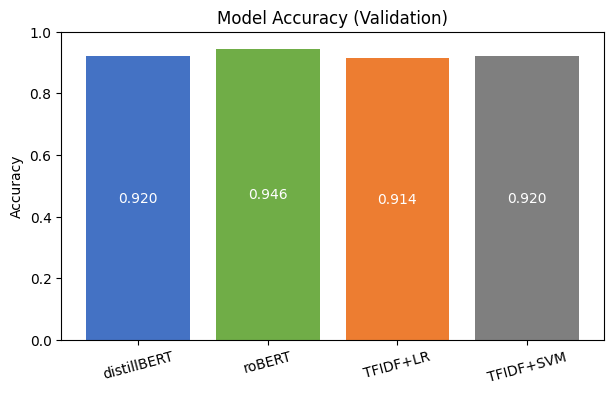

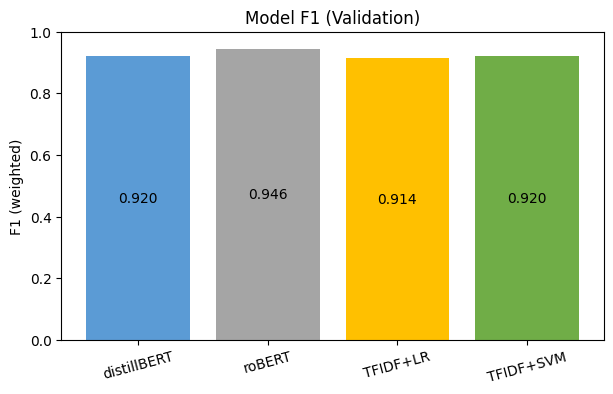

In [52]:
import matplotlib.pyplot as plt

models = ["distillBERT","roBERT", "TFIDF+LR", "TFIDF+SVM"]
accs   = [dbt_acc,rbt_acc, lr_acc, svm_acc]
f1s    = [dbt_f1, rbt_f1, lr_f1,  svm_f1]

# Accuracy
plt.figure(figsize=(7,4))
bars = plt.bar(models, accs, color=["#4472C4", "#70AD47", "#ED7D31", "#7F7F7F"])
plt.ylabel("Accuracy")
plt.title("Model Accuracy (Validation)")
plt.ylim(0,1)
plt.xticks(rotation=15)
for b, v in zip(bars, accs):
    plt.text(b.get_x() + b.get_width()/2, b.get_height()/2, f"{v:.3f}", ha="center", va="center", color="white", fontsize=10)
plt.show()

# F1
plt.figure(figsize=(7,4))
bars = plt.bar(models, f1s, color=["#5B9BD5", "#A5A5A5", "#FFC000", "#70AD47"])
plt.ylabel("F1 (weighted)")
plt.title("Model F1 (Validation)")
plt.ylim(0,1)
plt.xticks(rotation=15)
for b, v in zip(bars, f1s):
    plt.text(b.get_x() + b.get_width()/2, b.get_height()/2, f"{v:.3f}", ha="center", va="center", color="black", fontsize=10)
plt.show()


In [11]:
!pip install streamlit pyngrok

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 23.0 MB/s eta 0:00:00


In [12]:
from pyngrok import ngrok

!ngrok config add-authtoken 32rswUXPM6iVSG9TfbypX0cLHss_6WGidy5MQF2fbna7irCFk


Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


##BART Summarizer

In [13]:
import re
from transformers import pipeline, AutoTokenizer

summarizer = pipeline("summarization", model="facebook/bart-large-cnn", device_map="auto")
tok_sum = AutoTokenizer.from_pretrained("facebook/bart-large-cnn")

def _smart_lengths(text, ratio=(0.3, 0.6), caps=(20, 120)):
    n = len(tok_sum(text)["input_ids"])
    min_len = max(caps[0], int(ratio[0] * n))
    max_len = max(min_len + 5, min(caps[1], int(ratio[1] * n)))
    return min_len, max_len

def _tidy_summary(s):
    s = re.sub(r"\s+", " ", s).strip()
    def cap_after_boundary(m):
        return m.group(0)[:-1] + m.group(0)[-1].upper()
    s = re.sub(r"(^\s*[a-z])", lambda m: m.group(0).upper(), s)
    s = re.sub(r"(\.\s+)([a-z])", cap_after_boundary, s)
    s = re.sub(r"(\!\s+)([a-z])", cap_after_boundary, s)
    s = re.sub(r"(\?\s+)([a-z])", cap_after_boundary, s)
    if not re.search(r"[.!?]$", s):
        s += "."
    return s

def summarize_clean(text, ratio=(0.3, 0.6), caps=(20, 120)):
    min_len, max_len = _smart_lengths(text, ratio=ratio, caps=caps)
    out = summarizer(
        text,
        min_length=min_len,
        max_length=max_len,
        do_sample=False,
        num_beams=4,
        length_penalty=2.0,
        no_repeat_ngram_size=3
    )
    return _tidy_summary(out[0]["summary_text"])

Device set to use cpu


In [9]:
review = ("Test is a heartfelt drama that scores high on storytelling and performances. The film weaves an emotional narrative that resonates deeply, powered by a compelling script and a grounded portrayal of real-life struggles. The cast delivers standout performances—each actor bringing nuance and authenticity to their roles. Overall, Test is a well-made film with a strong heart. A bit of patience pays off here, making it a worthy watch for lovers of grounded, character-driven cinema.")
print(summarize_clean(review, ratio=(0.35, 0.6), caps=(24, 90)))

Test is a heartfelt drama that scores high on storytelling and performances. The film weaves an emotional narrative that resonates deeply. Overall, Test is a well-made film with a strong heart.


##Sarcasm detection

In [55]:
from transformers import pipeline
import re

sarcasm_t5 = pipeline("text2text-generation", model="mrm8488/t5-base-finetuned-sarcasm-twitter", device_map="auto")  # [web:141]

def detect_sarcasm_label(review: str) -> str:
    text = re.sub(r"\s+", " ", review).strip()
    raw = sarcasm_t5(text, max_length=3)[0]["generated_text"].strip().lower()  # 'derison' or 'normal' [web:141]
    return "SARCASTIC" if "derison" in raw else "NOT_SARCASTIC"

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Device set to use cuda:0


In [56]:
txt = "Yeah right, this was the best movie ever... not."
print(detect_sarcasm_label(txt))

Both `max_new_tokens` (=256) and `max_length`(=3) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


SARCASTIC


In [57]:
txt = "A beautifully acted drama with tight pacing and a moving score."
print(detect_sarcasm_label(txt))

Both `max_new_tokens` (=256) and `max_length`(=3) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


NOT_SARCASTIC


In [14]:
import re
import streamlit as st
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import nltk

In [57]:
%%writefile app.py

import re
import streamlit as st
from transformers import pipeline, AutoTokenizer
import time

st.set_page_config(
    page_title="🎬 IMDb Sentiment Analyzer",
    page_icon="🎭",
    layout="wide"
)

# Custom CSS for IMDb theme
st.markdown("""
<style>
/* ... your existing CSS unchanged ... */
    @import url('https://fonts.googleapis.com/css2?family=Roboto:wght@300;400;500;700&display=swap');
    .main-header { font-family: 'Roboto', sans-serif; font-size: 2.5rem; font-weight: 700; color: #F5C518; background-color: #000000; text-align: center; padding: 1rem; border-radius: 8px; margin-bottom: 2rem; border: 2px solid #F5C518; }
    .imdb-container { background-color: #1a1a1a; color: #ffffff; padding: 1.5rem; border-radius: 8px; border: 1px solid #333333; margin: 1rem 0; }
    .result-card { background-color: #2a2a2a; border: 1px solid #404040; border-radius: 8px; padding: 1.5rem; margin: 1rem 0; color: #ffffff; }
    .positive-result { border-left: 4px solid #5cb85c; background-color: #1e3a1e; }
    .negative-result { border-left: 4px solid #d9534f; background-color: #3a1e1e; }
    .sarcastic-result { border-left: 4px solid #f0ad4e; background-color: #3a2e1e; }
    .stButton > button { background-color: #F5C518; color: #000000; border: none; border-radius: 4px; padding: 0.5rem 1.5rem; font-weight: 500; font-family: 'Roboto', sans-serif; }
    .stButton > button:hover { background-color: #e6b800; }
    .stTextArea > div > div > textarea { background-color: #2a2a2a; color: #ffffff; border: 1px solid #404040; border-radius: 4px; font-family: 'Roboto', sans-serif; }
    .sample-button { background-color: #404040; color: #ffffff; border: 1px solid #666666; border-radius: 4px; padding: 0.5rem 1rem; margin: 0.25rem; font-family: 'Roboto', sans-serif; cursor: pointer; }
    .sample-button:hover { background-color: #555555; }
    .quick-tabs { display: flex; gap: 1rem; margin: 1rem 0; flex-wrap: wrap; }
    .tab-button { background-color: #404040; color: #ffffff; border: 1px solid #666666; border-radius: 4px; padding: 0.5rem 1rem; font-family: 'Roboto', sans-serif; cursor: pointer; transition: all 0.3s ease; }
    .tab-button:hover { background-color: #F5C518; color: #000000; }
    .summary-box { background-color: #2a2a2a; border: 1px solid #F5C518; border-radius: 8px; padding: 1rem; margin: 1rem 0; color: #ffffff; }
    .mixed-badge { display:inline-block; margin-left:8px; padding:2px 8px; border-radius:10px; background:#F5C518; color:#000; font-weight:600; font-size:0.85rem; }
</style>
""", unsafe_allow_html=True)

if 'selected_sample' not in st.session_state:
    st.session_state.selected_sample = None

@st.cache_resource
def load_models():
    """Load all ML models"""
    with st.spinner("🎬 Loading IMDb AI models..."):
        sentiment = pipeline(
            "text-classification",
            model="rohan10juli/roBERT-imdb-sentiment-tuned",
            device_map="auto"
        )
        sarcasm_t5 = pipeline(
            "text2text-generation",
            model="mrm8488/t5-base-finetuned-sarcasm-twitter",
            device_map="auto"
        )
        summarizer = pipeline(
            "summarization",
            model="facebook/bart-large-cnn",
            device_map="auto"
        )
        tok_sum = AutoTokenizer.from_pretrained("facebook/bart-large-cnn")
    return sentiment, sarcasm_t5, summarizer, tok_sum

# Helper functions
def clean_text(t: str) -> str:
    t = re.sub(r"<br\s*/?>", " ", str(t), flags=re.IGNORECASE)
    t = re.sub(r"\s+", " ", t).strip()
    return t

def _smart_lengths(text: str, ratio=(0.30, 0.60), caps=(20, 120)):
    n = len(tok_sum(text)["input_ids"])
    min_len = max(caps[0], int(ratio[0] * n))
    max_len = max(min_len + 5, min(caps[1], int(ratio[1] * n)))
    return min_len, max_len

def _tidy_summary(s: str) -> str:
    s = re.sub(r"\s+", " ", s).strip()
    s = re.sub(r"(^\s*[a-z])", lambda m: m.group(0).upper(), s)
    s = re.sub(r"([.!?]\s+)([a-z])", lambda m: m.group(1) + m.group(2).upper(), s)
    if not re.search(r"[.!?]$", s):
        s += "."
    return s

def summarize_clean(text: str, ratio=(0.30, 0.60), caps=(20, 120)) -> str:
    min_len, max_len = _smart_lengths(text, ratio=ratio, caps=caps)
    out = summarizer(
        text,
        min_length=min_len,
        max_length=max_len,
        do_sample=False,
        num_beams=4,
        length_penalty=2.0,
        no_repeat_ngram_size=3
    )
    return _tidy_summary(out[0]["summary_text"])

SARC_CUES = [
    r"\byeah right\b", r"\bas if\b", r"\bthanks for nothing\b",
    r"\bjust what i needed\b", r"\bso great\b.*\bnot\b", r"\bof course\b.*\bnot\b"
]

def _rule_sarcasm(text: str) -> bool:
    t = text.lower()
    return any(re.search(p, t) for p in SARC_CUES)

def detect_sarcasm_sentence_vote(text: str, frac_threshold: float = 0.25) -> tuple:
    sents = re.split(r'(?<=[.!?])\s+', text.strip())
    sents = [s for s in sents if s]
    if not sents:
        return "NOT_SARCASTIC", 0.0
    outs = sarcasm_t5(
        sents, max_length=3, do_sample=False, num_beams=1, temperature=0.01, top_k=1, top_p=1.0
    )
    sarcastic = 0
    for o in outs:
        raw = o["generated_text"].strip().lower()
        if raw.startswith("derison") or raw == "derision":
            sarcastic += 1
    frac = sarcastic / max(1, len(sents))
    label = "SARCASTIC" if frac >= frac_threshold else "NOT_SARCASTIC"
    return label, frac

def detect_sarcasm_label(text: str) -> tuple:
    t = re.sub(r"\s+", " ", text).strip()
    label, confidence = detect_sarcasm_sentence_vote(t, frac_threshold=0.25)
    if label == "NOT_SARCASTIC" and _rule_sarcasm(t):
        label = "SARCASTIC"
        confidence = 0.8
    return label, confidence

# Mixed-review detection

def _sentence_split(t: str):
    return [s for s in re.split(r'(?<=[.!?])\s+', t.strip()) if s]

def review_sentiment_mixed(text: str, pos_thresh=0.20, neg_thresh=0.20, neutral_margin=0.10) -> tuple:
    """
    Returns ('MIXED'|'POSITIVE'|'NEGATIVE', details_dict)
    details_dict = {'fpos': float, 'fneg': float, 'pos': int, 'neg': int, 'n_used': int}
    """
    sents = _sentence_split(text)
    if not sents:
        return "NEGATIVE", {'fpos': 0.0, 'fneg': 0.0, 'pos': 0, 'neg': 0, 'n_used': 0}
    preds = sentiment_model(sents)
    pos = neg = 0
    used = 0
    for p in preds:
        label = p["label"].lower()
        score = p.get("score", 0.5)
        if (0.5 - neutral_margin) < score < (0.5 + neutral_margin):
            continue
        used += 1
        if "pos" in label:
            pos += 1
        elif "neg" in label:
            neg += 1
    n = max(1, pos + neg)
    fpos, fneg = pos / n, neg / n
    if fpos >= pos_thresh and fneg >= neg_thresh:
        overall = "MIXED"
    else:
        overall = "POSITIVE" if fpos > fneg else "NEGATIVE"
    return overall, {'fpos': fpos, 'fneg': fneg, 'pos': pos, 'neg': neg, 'n_used': used}

st.markdown('<h1 class="main-header">🎬 IMDb Sentiment Analyzer</h1>', unsafe_allow_html=True)

sentiment_model, sarcasm_t5, summarizer, tok_sum = load_models()

st.markdown('<div class="imdb-container">', unsafe_allow_html=True)
st.markdown("### Quick Sample Reviews")

sample_reviews = {
    "Positive Blockbuster": "The opening twenty minutes glide by on confident filmmaking—clean geography, generous wide shots, and a score that swells without smothering. The lead performance anchors every turn; small gestures pay off later as the character’s choices tighten the plot. Jokes land because they grow out of behavior, not mugging, and the action escalates with purpose rather than noise. By the finale, stakes feel personal and the resolution is cathartic without tipping into syrup. It’s mainstream entertainment built with craft and heart.",
    "Negative Disaster": "The film never finds its rhythm. Key scenes are rushed, character motivations are underdeveloped, and the middle act wanders through subplots that don’t affect the outcome. Action sequences are loud but incoherent, with choppy editing that obscures basic geography. By the finale, conflicts are resolved through convenient twists rather than earned choices, leaving a flat, unsatisfying experience.",
    "Sarcastic Review": "Oh yes, a true masterpiece—endless exposition, recycled twists, and action scenes that repeat like a broken GIF. The characters posture while the plot sprints in circles, and by the time the villain explains his plan for the third time, the only suspense is whether the credits will save us.",
    "Mixed Feelings": "I honestly don't understand why Test (2025) faced so much rejection. Sure, the storyline had its weak moments, but overall, it was engaging enough to hold my attention. What truly stood out were the fantastic performances by R. Madhavan and Siddharth—they brought depth and emotion that really elevated the film. Yes, the plot could have been tighter, and at times it felt like it lacked direction. But the lead actors carried the movie with such conviction that it still worked for me. All in all, I'd say Test is a good one-time watch, especially if you appreciate solid performances. Don't go in expecting a masterpiece—but it's definitely not as bad as some are making it out to be."
}

cols = st.columns(len(sample_reviews))
for i, (title, review) in enumerate(sample_reviews.items()):
    with cols[i]:
        if st.button(title, key=f"sample_{i}", use_container_width=True):
            st.session_state.selected_sample = review

st.markdown('</div>', unsafe_allow_html=True)

# Input section
st.markdown('<div class="imdb-container">', unsafe_allow_html=True)
st.markdown("### ✍️ Enter Your Movie Review")

default_text = st.session_state.selected_sample if st.session_state.selected_sample else ""

user_input = st.text_area(
    "Movie Review:",
    height=200,
    placeholder="Enter your movie review here... (or click a sample above)",
    value=default_text,
    help="Paste any movie review to analyze its sentiment and detect sarcasm"
)

# Action buttons
col1, col2 = st.columns([3, 1])
with col1:
    analyze_btn = st.button(" Analyze Review", type="primary", use_container_width=True)
with col2:
    if st.button(" Clear", use_container_width=True):
        st.session_state.selected_sample = None
        st.rerun()

st.markdown('</div>', unsafe_allow_html=True)

# Analysis section
if analyze_btn and user_input.strip():
    text = clean_text(user_input)
    with st.spinner(" Analyzing your review..."):
        sarcasm_label, sarcasm_confidence = detect_sarcasm_label(text)
        s_out = sentiment_model(text)[0]
        sent_label = s_out["label"]
        sent_score = s_out.get("score", 0)
        summary = summarize_clean(text)
        mixed_label, mixed_meta = review_sentiment_mixed(text)  # NEW

    # Results display
    st.markdown("## Analysis Results")
    col1, col2 = st.columns(2)


    with col1:
        badge = f'<span class="mixed-badge">MIXED</span>' if mixed_label == "MIXED" else ""
        if "pos" in sent_label.lower():
            st.markdown(f'''
            <div class="result-card positive-result">
                <h3>😊 Sentiment: POSITIVE {badge}</h3>
                <p>This review expresses positive feelings about the movie.</p>
            </div>
            ''', unsafe_allow_html=True)
        else:
            st.markdown(f'''
            <div class="result-card negative-result">
                <h3>😞 Sentiment: NEGATIVE {badge}</h3>
                <p>This review expresses negative feelings about the movie.</p>
            </div>
            ''', unsafe_allow_html=True)

    # Sarcasm result
    with col2:
      THRESHOLD = 0.50

      if sarcasm_confidence >= THRESHOLD:
          st.markdown(f'''
          <div class="result-card sarcastic-result">
              <h3>🎭 Sarcasm: DETECTED</h3>
              <p>⚠️ This review contains sarcasm. The sentiment analysis may not reflect the true opinion.</p>
          </div>
          ''', unsafe_allow_html=True)
      else:
          st.markdown(f'''
          <div class="result-card">
              <h3>✅ Sarcasm: NOT DETECTED</h3>
              <p>The review appears to be straightforward without sarcasm.</p>
          </div>
          ''', unsafe_allow_html=True)


    st.markdown(f'''
    <div class="summary-box">
        <h3>📝 Review Summary</h3>
        <p style="font-size: 1.1em; line-height: 1.6;">{summary}</p>
    </div>
    ''', unsafe_allow_html=True)

st.markdown("---")
st.markdown('''
<div style="text-align: center; color: #888; padding: 1rem; font-family: 'Roboto', sans-serif;">
    <p><strong> Powered by Advanced AI Models</strong></p>
    <p>Sentiment: RoBERTa-IMDb | Sarcasm: T5-Sarcasm | Summary: BART-CNN</p>
</div>
''', unsafe_allow_html=True)


Overwriting app.py


In [58]:
from pyngrok import ngrok
ngrok.kill()
public_url = ngrok.connect(8501)
print("Streamlit URL:", public_url)
!streamlit run app.py --server.port 8501

Streamlit URL: NgrokTunnel: "https://b4a28f7c087c.ngrok-free.app" -> "http://localhost:8501"



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.31.58.81:8501



2025-09-25 08:56:33.351965: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758790593.378805   36358 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758790593.386944   36358 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1758790593.406415   36358 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1758790593.406455   36358 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1758790593.406460   36358 computation_placer.cc:177] computation placer alr

In [59]:
!jupyter nbconvert --ClearMetadataPreprocessor.enabled=True --imdb_sentiment.ipynb


usage: jupyter-nbconvert [-h] [--debug] [--show-config] [--show-config-json]
                         [--generate-config] [-y] [--execute] [--allow-errors]
                         [--stdin] [--stdout] [--inplace] [--clear-output]
                         [--coalesce-streams] [--no-prompt] [--no-input]
                         [--allow-chromium-download]
                         [--disable-chromium-sandbox] [--show-input]
                         [--embed-images] [--sanitize-html]
                         [--log-level NbConvertApp.log_level]
                         [--config NbConvertApp.config_file]
                         [--to NbConvertApp.export_format]
                         [--template TemplateExporter.template_name]
                         [--template-file TemplateExporter.template_file]
                         [--theme HTMLExporter.theme]
                         [--sanitize_html HTMLExporter.sanitize_html]
                         [--writer NbConvertApp.writer_class]
   